In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Store SNP weights

In [3]:
if os.path.exists("out/snp_weights.tsv.gz"):
    df_weight = pd.read_csv("out/snp_weights.tsv.gz", sep="\t")
else:
    DATA_DIR = "/u/home/k/kangchen/PAGE-QC/01-dataset/out/aframr"

    df_freq = (
        pd.concat(
            [
                pd.read_csv(
                    f"{DATA_DIR}/imputed/chr{chrom}.freq",
                    delim_whitespace=True,
                )
                for chrom in range(1, 23)
            ]
        )
        .reset_index(drop=True)
        .set_index("ID")
    )

    df_weight = pd.read_csv(
        f"{DATA_DIR}/grm/imputed.mafukb.all.weight.tsv",
        delim_whitespace=True,
    ).set_index("snp")
    df_weight["PRIOR_VAR"] /= df_weight["PRIOR_VAR"].sum()
    df_weight["FREQ"] = df_freq["ALT_FREQS"].reindex(df_weight.index)
    df_weight["FREQ_VAR"] = 2 * df_weight["FREQ"] * (1 - df_weight["FREQ"])
    df_weight.to_csv("out/snp_weights.tsv.gz", index=False, sep="\t")

In [9]:
scale_factor

0.24884752564563367

In [4]:
# see how to generate "results/raw.csv" in 01-plot-simulation.ipynb
df_plot = pd.read_csv("results/raw.csv")
df_weights = pd.read_csv("out/snp_weights.tsv.gz", sep="\t")
scale_factor = np.sum(df_weights["PRIOR_VAR"] * df_weights["FREQ_VAR"])
df_plot["estimated_var_g"] *= scale_factor

In [5]:
df_plot = df_plot[
    ["estimated_var_g", "estimated_var_e", "hsq", "cor", "pcausal"]
].copy()
df_plot["estimated_hsq"] = df_plot["estimated_var_g"] / (
    df_plot["estimated_var_g"] + df_plot["estimated_var_e"]
)

In [6]:
df_mean = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: pd.Series({"mean": np.mean(x["estimated_hsq"])})
)
df_sem = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: pd.Series({"sem": np.std(x["estimated_hsq"]) / np.sqrt(len(x))})
)
df_plot = pd.merge(df_mean, df_sem, left_index=True, right_index=True).reset_index()

In [7]:
# x = h2g, hue = rg, y=h2g, panel = pcausal

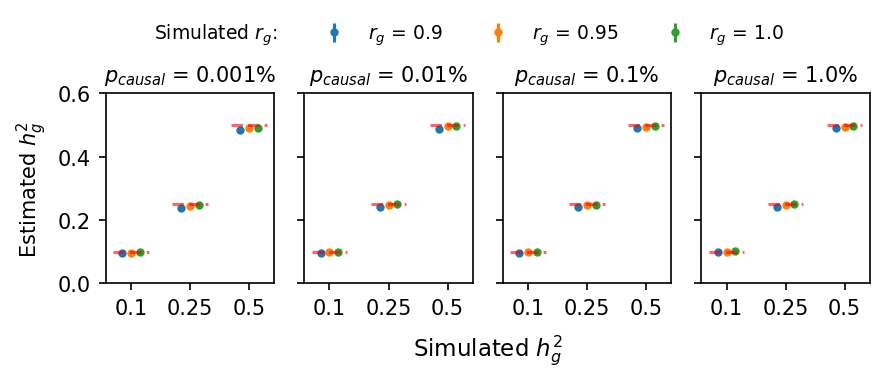

In [8]:
fig, axes = plt.subplots(figsize=(6, 2), dpi=150, ncols=4, sharey=True)
for i_pcausal, pcausal in enumerate(df_plot.pcausal.unique()):
    for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
        df_tmp = df_plot[(df_plot.pcausal == pcausal) & (df_plot.cor == cor)]
        axes[i_pcausal].errorbar(
            x=np.arange(len(df_tmp)) + (i_cor - 1) * 0.15,
            y=df_tmp["mean"],
            yerr=df_tmp["sem"] * 1.96,
            fmt=".",
            label=f"$r_g$ = {cor}",
        )
    # x-axis
    axes[i_pcausal].set_xticks([0, 1, 2])
    axes[i_pcausal].set_xticklabels([0.1, 0.25, 0.5])

    # y-axis
    axes[i_pcausal].set_ylim(0, 0.6)
    if i_pcausal == 0:
        axes[i_pcausal].set_ylabel("Estimated $h_g^2$")

    # title
    axes[i_pcausal].set_title("$p_{causal}$ = " + f"{pcausal * 100}%", fontsize=10)
    for i_hsq, hsq in enumerate([0.1, 0.25, 0.5]):
        axes[i_pcausal].hlines(
            y=hsq,
            xmin=i_hsq - 0.3,
            xmax=i_hsq + 0.3,
            color="red",
            ls="--",
            alpha=0.6,
            zorder=10,
        )

fig.text(
    0.55,
    -0.05,
    "Simulated $h_g^2$",
    fontsize=11,
    ha="center",
)

handles, labels = axes[0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $r_g$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.tight_layout()
fig.savefig("results/estimate-hsq.pdf", bbox_inches="tight")